In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytpc
import seaborn as sns
import math
import matplotlib.pyplot as plt
import h5py
import heapq

In [8]:
def hough_circle(xyzs):
    nbins = 200
    xyz_order = xyzs[np.argsort(xyzs[:,2])]
    th = np.linspace(0,math.pi,nbins)
    #H = [0,0]
    Hrad = [0,0]
    xyz_order_f = xyz_order[5:]
    xyz_order = xyz_order[:-5]

   # return xyz_order, xyz_order_f
    for theta in th:
        Radius = (xyz_order_f[:,0]**2 - xyz_order[:,0]**2+ xyz_order_f[:,1]**2- xyz_order[:,1]**2)/(2*((xyz_order_f[:,0]- xyz_order[:,0])*np.cos(theta)+(xyz_order_f[:,1]- xyz_order[:,1])*np.sin(theta)))
        index = 0
        for rr in Radius:  
            aRad = np.hstack((theta,Radius[index]))
            Hrad = np.vstack((Hrad,aRad))
            index +=1

    Hrad = Hrad[1:]
    
    #countsRad, xedgesRad, yedgesRad, ImageRad = plt.hist2d(Hrad[:,0], Hrad[:,1], nbins,range=[[0,math.pi],[-500,500]],cmap=plt.cm.jet) 
    countsRad, xedgesRad, yedgesRad = np.histogram2d(Hrad[:,0], Hrad[:,1], nbins,range=[[0,math.pi],[-500,500]])

    iRad,jRad = np.unravel_index(countsRad.argmax(), countsRad.shape)

    tRad = iRad*math.pi/nbins
    rRad = jRad*1000/nbins - 500
   
    print(rRad,tRad)
  
    ax =  rRad*math.cos(tRad)  
    by =  rRad*math.sin(tRad)
  
    return ax,by

In [5]:
h5_filename = '../run_0166_peaks_bkd_subtract.h5'
group_name = '/reduced_get_events'
file = h5py.File(h5_filename,'r')
group = file[group_name]

In [11]:
i = 0

In [85]:
#ev = '128'
print(i)
ev = str(i)
event = group[ev]
xyz = event[:,0:4]
#plt.plot(xyz[:,0],xyz[:,1],'.')
#fig = plt.figure()
#ax = fig.add_subplot(111,projection='3d')
#cmhot = plt.get_cmap("jet")
#a = ax.scatter(xyz[:,0],xyz[:,1],xyz[:,2],c=xyz[:,3],cmap=cmhot)
#fig.colorbar(a)

18


TypeError: Argument sequence too long

In [ ]:
a, b = hough_circle(xyz)

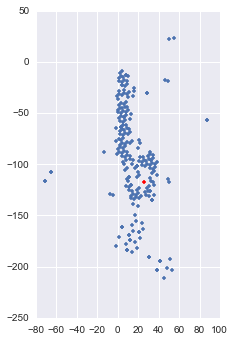

In [83]:
plt.plot(xyz[:,0],xyz[:,1],'.',a,b,'r.')
plt.axes().set_aspect(1)


In [84]:
i = i+1